# Neural Networks - Project 2: Tensorflow

Deadline: 24.01.2023

## Dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import (Resizing, Rescaling,
                                     RandomFlip, RandomRotation, RandomZoom,
                                     Input, Dense, BatchNormalization, Conv2D, ELU, MaxPool2D, Flatten, SeparableConv2D, GlobalAveragePooling2D, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from tensorflow.keras.applications import MobileNetV2

<a id='exercise-1'></a>
## Excercise 1 (1 pt)

Using the tensorflow_datasets package (https://www.tensorflow.org/datasets/), import the dataset of your own choice for image classification(other than CatsVsDogs). Split the dataset into: training, validation and test set in reasonable proportions.


For my project I will be using the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. It contains 3670 examples in only a "train" split, with 5 different labels ('dandelion', 'daisy', 'tulips', 'sunflowers', 'roses').

I'll perform a 80/10/10 split, as it is the most popular/common split. [Read more](https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438)

Number of samples in original dataset:  3670
Number of samples in train dataset:  2936
Number of samples in validation dataset:  367
Number of samples in test dataset:  367

Number of classes:  5
Class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
[739 513 613 561 510]


<ipython-input-2-bc76897d655d>:40: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


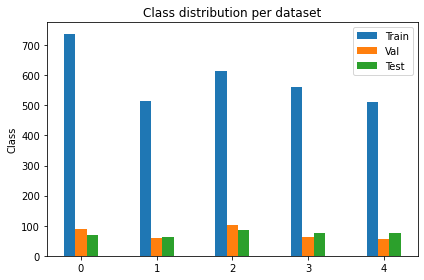

In [ ]:
# Load the dataset with TensorFlow Datasets, with apropriate split
(train_ds_raw, val_ds_raw, test_ds_raw), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)

# Print the number of samples in the dataset (only train split is provided in tensorflow for this particular dataset)
print("Number of samples in original dataset: ", info.splits['train'].num_examples)
print("Number of samples in train dataset: ", len(train_ds_raw))
print("Number of samples in validation dataset: ", len(val_ds_raw))
print("Number of samples in test dataset: ", len(test_ds_raw))

# Print the number of classes
num_classes = info.features['label'].num_classes
labels = info.features['label'].names
print("\nNumber of classes: ", num_classes)
print("Class names: ", labels)


# Plot Class distribution
vals_train = np.unique(np.fromiter(train_ds_raw.map(lambda x, y: y), float), return_counts=True)
vals_val = np.unique(np.fromiter(val_ds_raw.map(lambda x, y: y), float), return_counts=True)
vals_test = np.unique(np.fromiter(test_ds_raw.map(lambda x, y: y), float), return_counts=True)

print(vals_train[1][:5])

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
bar_train = ax.bar(x - width, vals_train[1], width, label='Train')
bar_val = ax.bar(x, vals_val[1], width, label='Val')
bar_test = ax.bar(x + width, vals_test[1], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_ylabel('Class')
ax.set_title('Class distribution per dataset')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

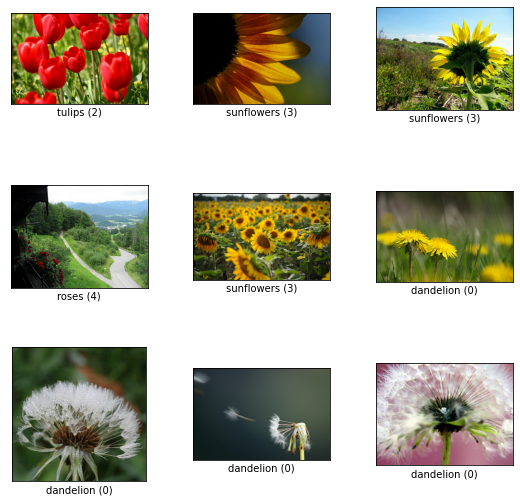

In [ ]:
# Display examples from the dataset
fig = tfds.show_examples(train_ds_raw, info)

## Excercise 2 (2 pts)

Implement the data augmentation layers. Draw an exemplary image and its several augmented versions.

For this section I followed the [TensorFlow Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation) alongside the other mentioned References.

### Resize and normalize images

First we need to [resize](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing) the images to a fixed size, and [rescale](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) the pixel values to be in the [0, 1] range ([-1, 1] range is needed later for transfer learning to MobileNetV2)

In [ ]:
IMG_SIZE = 224

# Resize image to 224x224, and rescale to [0, 1] range
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1./255)
])

# Resize image to 224x224, and rescale to [-1, 1] range
resize_and_rescale_mnv2 = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(scale=1./127.5, offset=-1)
])

### Define the transformations for data augmentation

- [Random flip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) image horizontally
- [Random rotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) in 0 to 20 degrees range
- [Random zoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) in range 30%

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal", seed=42),
  RandomRotation(0.2, seed=42),
  RandomZoom((-0.3, 0), seed=42),
])

### Function to wrap all the preprocessing

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False, mnv2=False):
  # Resize and rescale all datasets.
  if mnv2:
    ds = ds.map(lambda x, y: (resize_and_rescale_mnv2(x), y), 
              num_parallel_calls=AUTOTUNE)
  else:
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  
  # Shuffle dataset
  if shuffle:
    ds = ds.shuffle(1000, seed=42)
  
  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Configure the dataset for performance, return it
  return ds.cache().prefetch(buffer_size=AUTOTUNE)


# Preprocess all the datasets
train_ds = prepare(train_ds_raw, shuffle=True, augment=True)
val_ds = prepare(val_ds_raw)
test_ds = prepare(test_ds_raw)

### Visualize an augmentation example

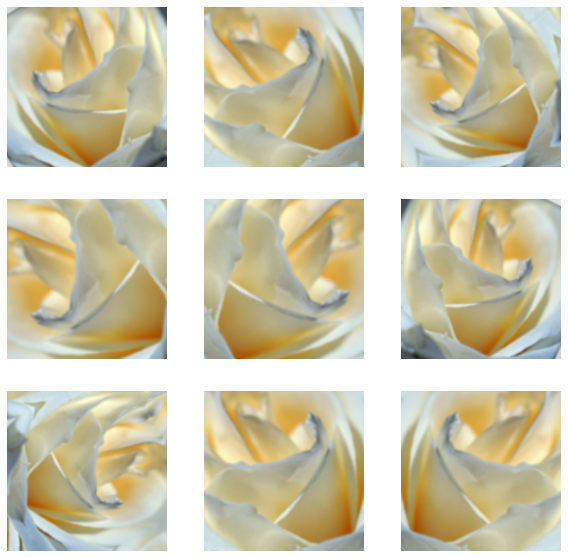

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[2]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

## Excercise 3 (2 pts)

Propose your own CNN architecture and try to learn it on your dataset. Keep the values of loss and accuracy in a history object.

### Define CNN architecture

In [ ]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_flowers')

x = Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides=2, padding="same")(x)
x = Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides=2, padding="same")(x)
x = Conv2D(128, 3, strides=1, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides=2, padding="same")(x)
x = Conv2D(256, 3, strides=1, padding="same", activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides=2, padding="same")(x)
x = Conv2D(512, 3, strides=1, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(2, strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(1000, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(num_classes, activation='softmax', name='outputs')(x)

model_cnn = Model(inputs=inputs, outputs=outputs, name='Flowers_CNN')
model_cnn.summary()

Model: "Flowers_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_flowers (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     

### [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) and [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) model

In [ ]:
initial_epochs = 10

model_cnn.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

history_cnn = model_cnn.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, verbose=1)

Epoch 1/10
92/92 [==============================] - 37s 298ms/step - loss: 10.9999 - sparse_categorical_accuracy: 0.3794 - val_loss: 8.5490 - val_sparse_categorical_accuracy: 0.2425
Epoch 2/10
92/92 [==============================] - 8s 90ms/step - loss: 1.9796 - sparse_categorical_accuracy: 0.4530 - val_loss: 4.1663 - val_sparse_categorical_accuracy: 0.2452
Epoch 3/10
92/92 [==============================] - 8s 90ms/step - loss: 1.1806 - sparse_categorical_accuracy: 0.5419 - val_loss: 4.3047 - val_sparse_categorical_accuracy: 0.2643
Epoch 4/10
92/92 [==============================] - 8s 91ms/step - loss: 1.0349 - sparse_categorical_accuracy: 0.5906 - val_loss: 3.8482 - val_sparse_categorical_accuracy: 0.3052
Epoch 5/10
92/92 [==============================] - 8s 91ms/step - loss: 0.9675 - sparse_categorical_accuracy: 0.6233 - val_loss: 1.9279 - val_sparse_categorical_accuracy: 0.4986
Epoch 6/10
92/92 [==============================] - 8s 92ms/step - loss: 0.8663 - sparse_categorical_a

12/12 [==============================] - 0s 28ms/step - loss: 1.4273 - sparse_categorical_accuracy: 0.5967


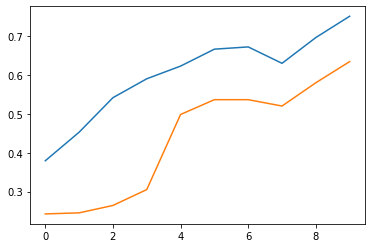

In [ ]:
loss_cnn, accuracy_cnn = model_cnn.evaluate(test_ds)

plt.plot(history_cnn.history['sparse_categorical_accuracy'])
plt.plot(history_cnn.history['val_sparse_categorical_accuracy'])

## Excerise 4 (4 pts)

Do the transfer learning, using a base model different from the VGG16. Keep the values of loss and accuracy in a history object.

For exercise 4 and 5 I followed the [TensorFlow Transfer learning and fine-tuning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning) alongside the other mentioned References.

### MobileNet V2

In this exercise I will perform transfer learning using the [MobileNet V2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) base model.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
base_mnv2 = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_mnv2.trainable = False # Freeze the convolutional base
base_mnv2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

### Transfer learning model

Now we create the new model, including once again a Dropout layer to prevent overfitting.

The 2.3 million parameters in MobileNet are frozen, but there are 6405 trainable parameters in the Dense layer.

In [ ]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_flowers')
x = base_mnv2(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax', name='outputs')(x)

model_mnv2 = Model(inputs=inputs, outputs=outputs, name='Flowers_MNV2')
model_mnv2.summary()

Model: "Flowers_MNV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_flowers (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-tr

### Preprocess datasets for MobileNet V2

In [ ]:
train_ds_mnv2 = prepare(train_ds_raw, shuffle=True, augment=True, mnv2=True)
val_ds_mnv2 = prepare(val_ds_raw, mnv2=True)
test_ds_mnv2 = prepare(test_ds_raw, mnv2=True)

### Compile and fit

In [ ]:
base_learning_rate = 0.0001
model_mnv2.compile(optimizer=Adam(learning_rate=base_learning_rate), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

history_mnv2 = model_mnv2.fit(train_ds_mnv2, validation_data=val_ds_mnv2, epochs=initial_epochs, verbose=1)

Epoch 1/10
92/92 [==============================] - 28s 267ms/step - loss: 1.6768 - sparse_categorical_accuracy: 0.3130 - val_loss: 1.2685 - val_sparse_categorical_accuracy: 0.4959
Epoch 2/10
92/92 [==============================] - 4s 46ms/step - loss: 1.2517 - sparse_categorical_accuracy: 0.4966 - val_loss: 1.0018 - val_sparse_categorical_accuracy: 0.6458
Epoch 3/10
92/92 [==============================] - 4s 46ms/step - loss: 1.0092 - sparse_categorical_accuracy: 0.6131 - val_loss: 0.8455 - val_sparse_categorical_accuracy: 0.7166
Epoch 4/10
92/92 [==============================] - 4s 46ms/step - loss: 0.8785 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.7451 - val_sparse_categorical_accuracy: 0.7493
Epoch 5/10
92/92 [==============================] - 4s 46ms/step - loss: 0.7732 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.7738
Epoch 6/10
92/92 [==============================] - 4s 46ms/step - loss: 0.6946 - sparse_categorical_ac

12/12 [==============================] - 1s 39ms/step - loss: 0.4828 - sparse_categorical_accuracy: 0.8529


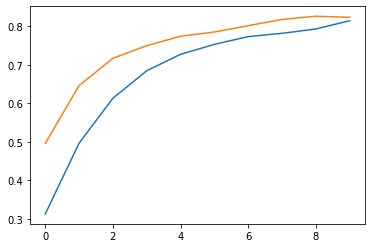

In [ ]:
loss_mnv2, accuracy_mnv2 = model_mnv2.evaluate(test_ds_mnv2)

plt.plot(history_mnv2.history['sparse_categorical_accuracy'])
plt.plot(history_mnv2.history['val_sparse_categorical_accuracy'])

## Excercise 5 (4 pts)

Do the fine-tuning of your network from Ex. 4, "freezing" a part of convolutional layers of your base model. Keep the values of loss and accuracy in a history object.

### Un-freeze top layers

I will un-freeze the top layers of the model, so they become trainable.

In [ ]:
base_mnv2.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_mnv2.layers))

Number of layers in the base model:  154


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_mnv2.layers[:fine_tune_at]:
  layer.trainable = False

model_mnv2.summary()

Model: "Flowers_MNV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_flowers (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 1,867,845
No

In [ ]:
len(model_mnv2.trainable_variables)

56

### Compile and fit fine-tuned model

As I am training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, the model could overfit very quickly.

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

model_mnv2.compile(optimizer=Adam(learning_rate=base_learning_rate/10), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])
history_tuned = model_mnv2.fit(train_ds_mnv2, validation_data=val_ds_mnv2, epochs=total_epochs, initial_epoch=history_mnv2.epoch[-1], verbose=1)

Epoch 10/20
92/92 [==============================] - 10s 76ms/step - loss: 0.4436 - sparse_categorical_accuracy: 0.8379 - val_loss: 0.3648 - val_sparse_categorical_accuracy: 0.8610
Epoch 11/20
92/92 [==============================] - 6s 65ms/step - loss: 0.3269 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.3118 - val_sparse_categorical_accuracy: 0.8856
Epoch 12/20
92/92 [==============================] - 6s 65ms/step - loss: 0.2556 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.3046 - val_sparse_categorical_accuracy: 0.8774
Epoch 13/20
92/92 [==============================] - 6s 66ms/step - loss: 0.2073 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.2705 - val_sparse_categorical_accuracy: 0.8992
Epoch 14/20
92/92 [==============================] - 6s 65ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.9414 - val_loss: 0.3099 - val_sparse_categorical_accuracy: 0.8937
Epoch 15/20
92/92 [==============================] - 6s 66ms/step - loss: 0.1458 - sparse_categoric

In [ ]:
loss_tuned, accuracy_tuned = model_mnv2.evaluate(test_ds_mnv2)

12/12 [==============================] - 0s 37ms/step - loss: 0.1964 - sparse_categorical_accuracy: 0.9155


## Excercise 6 (2 pts)

Compare (on plots) the accuraces and loss functon values for models from Ex. 3, 4, 5, both for the training and validation datasets. Present accuracies of all the models for the testing dataset.

### Compare plots

In [ ]:
def visualize(history, title, history_tuned=None):
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  if history_tuned:
    acc += history_tuned.history['sparse_categorical_accuracy']
    val_acc += history_tuned.history['val_sparse_categorical_accuracy']
    loss += history_tuned.history['loss']
    val_loss += history_tuned.history['val_loss']    

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  if history_tuned:
    plt.ylim([0.6, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy for model ' + title)

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  if history_tuned:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.title('Training and Validation Loss for model ' + title)
  plt.xlabel('epoch')
  plt.show()

#### Ex3 - CNN

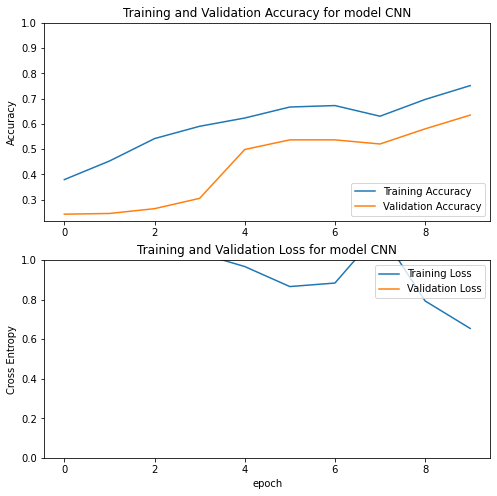

In [ ]:
visualize(history_cnn, 'CNN')

#### Ex4 - MobileNet V2

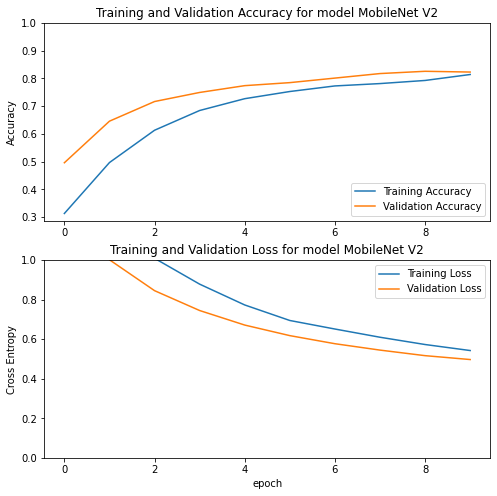

In [ ]:
visualize(history_mnv2, 'MobileNet V2')

#### Ex5 - MobileNet V2 Fine Tuned

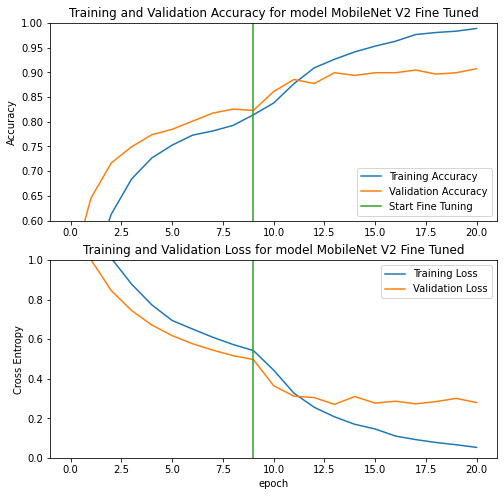

In [ ]:
visualize(history_mnv2, 'MobileNet V2 Fine Tuned', history_tuned=history_tuned)

### Compare accuracies on Test dataset

In [ ]:
print('Test accuracy for CNN: ', accuracy_cnn)
print('Test loss for CNN: ', loss_cnn)


print('\nTest accuracy for MobileNetV2: ', accuracy_mnv2)
print('Test loss for MobileNetV2: ', loss_mnv2)

print('\nTest accuracy for MobileNetV2 Fine Tuned: ', accuracy_tuned)
print('Test loss for MobileNetV2 Fine Tuned: ', loss_tuned)

Test accuracy for CNN:  0.5967302322387695
Test loss for CNN:  1.4272814989089966

Test accuracy for MobileNetV2:  0.8528610467910767
Test loss for MobileNetV2:  0.48280829191207886

Test accuracy for MobileNetV2 Fine Tuned:  0.9155313372612
Test loss for MobileNetV2 Fine Tuned:  0.19638103246688843


## Conclusions

From the plots and results presented above I can conclude:
- My CNN architecture is not good enough to perform well on this dataset, as it only reaches 0.6 accuracy on the test set, and has really big loss value for validation, with 1.42 test loss. Also, from the big gap between the accuracy curve (and loss) in the training and validation sets, we can see that it is really overfitting, despite having implemented some Dropout layers. This is probably due to the fact that the dataset is too small, and the CNN architecture is too simple.

- When I fist apply transfer learning using MobileNet V2, the accuracy is good, with 0.83 test accuracy, but the test loss, 0.48, could be lower. Nevertheless, the model is not overfitting, as the gap between the training and validation accuracy (and loss) is small.

- After fine-tuning the MobileNet V2 model, the accuracy is even better, with great 0.92 test accuracy, and the 0.2 test loss. In the plot, after the green line is when the fine tuning was applied for the MobileNet V2 model, for 10 more epochs. For the first 2 epochs we can see training and validation loss going down, but after that the validation loss stays stable while the training loss keeps going down. A similar behaviour is present for the accuracy, with the validation accuracy staying stable while the training accuracy keeps going up. This is probably due to the fact that the model is already very good, and the fine tuning is not improving it much (the model is only adapting to the training dataset, and not generalizing to the validation dataset).

## Aditional References

https://www.kaggle.com/code/dcpatton/tensorflow-2-flowers-cnn/notebook

https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc

https://www.kaggle.com/code/leifuer/flowers-with-transfer-learning-mobilenet-keras/notebook

https://www.kaggle.com/code/aizardar/transfer-learning-xception-on-flowers-dataset